# Fashion Dataset - Recommendation System

The dataset used for this project is the Fashion Product Images dataset found on Kaggle:

https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset/data

This dataset contains over 44,000 fashion products with multiple categorical labels, descriptions, and high-resolution images. This dataset contains a wide variety of items, including purses, shirts, dresses, shoes, and lipstick, just to name a few. This variety makes this dataset ideal for developing a recommendation system.

# The Problem

In the fashion industry, recommendation systems play a crucial role in sales as well as creating a personalised shopping experience for users. Although this is an effective method for personalised recommendations, it underutilises the visual similarity between products, which may heighten the user experience while shopping online. Visual characteristics such as colour, texture, and design are often the features of clothing that users find attractive or unattractive, showing a need for a visually similar fashion recommendation system.

To address this problem, a visually similar recommendation system will be developed that utilises a pre-trained convolutional neural network (CNN) for feature extraction. This model was previously trained on a large image dataset (ImageNet), which will allow the model to effectively learn visual features such as edges, shapes, and textures of fashion products.

A Nearest Neighbour algorithm will then use the extracted feature embeddings to find visually similar images.

This approach leverages deep learning and a similarity-based retrieval technique. This project will demonstrate a practical application of computer vision in a real-world situation involving e-commerce, helping users find products that match their visual fashion preferences.

In [ ]:
# Install older version of tensorflow as the newest version is not compatible with tensorflow_addons (depreciated tensorflow library)
!pip install tensorflow==2.15.0

Since this code is executed in a Google Colab environment, there is no need to manually install or import google.colab. However, if you plan to run this code in a different environment, you may need to install it manually using the following command:


```
!pip install google-colab
```



In [ ]:
# Upload Kaggle API credentials for dataset access
from google.colab import files
files.upload()  # Prompts file upload for kaggle.json, the Kaggle API key

In [ ]:
# Set up Kaggle API key for downloading datasets
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/  # Copy kaggle.json to the Kaggle config directory
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions for security

In [ ]:
# Download the fashion dataset from Kaggle
!kaggle datasets download -d paramaggarwal/fashion-product-images-dataset

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset
License(s): MIT
100% 23.1G/23.1G [20:14<00:00, 19.3MB/s]
100% 23.1G/23.1G [20:14<00:00, 20.4MB/s]


In [ ]:
 # Unzip the downloaded dataset
!unzip fashion-product-images-dataset.zip

In [ ]:
!pip install tensorflow_addons

In [ ]:
# Import libraries for data handling, visualization, and model building
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import os
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors


# Data Preprocessing

Here I load in the datasets 'images.csv' and 'styles.csv' to explore what features are present in the datasets. Based on a common feature, I will try to merge the datasets into one for training.

In [ ]:
# Load image metadata
images_df = pd.read_csv("../content/fashion-dataset/fashion-dataset/images.csv", on_bad_lines='skip')
images_df

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...
...,...,...
44441,17036.jpg,http://assets.myntassets.com/v1/images/style/p...
44442,6461.jpg,http://assets.myntassets.com/v1/images/style/p...
44443,18842.jpg,http://assets.myntassets.com/v1/images/style/p...
44444,46694.jpg,http://assets.myntassets.com/v1/images/style/p...


In [ ]:
# Load style metadata
styles_df = pd.read_csv("../content/fashion-dataset/fashion-dataset/styles.csv", on_bad_lines='skip')
styles_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume


I notice 'filename' in images_df is quite similar to 'id' in styles_df. I will use these features to merge the datasets. However, I must first create a new column in images_df from the existing feature 'filename' by duplicating it then removing the file format '.jpg' from the end of each instance.

In [ ]:
# Create id column for images_df to merge with styles_df by duplicating filename column and removing .jpg from each id
images_df['id'] = images_df['filename']
images_df['id'] = images_df['id'].str.replace('.jpg', '', regex=False).astype(int)
images_df

,filename,link,id
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...,15970
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...,39386
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...,59263
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...,21379
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...,53759
...,...,...,...
44441,17036.jpg,http://assets.myntassets.com/v1/images/style/p...,17036
44442,6461.jpg,http://assets.myntassets.com/v1/images/style/p...,6461
44443,18842.jpg,http://assets.myntassets.com/v1/images/style/p...,18842
44444,46694.jpg,http://assets.myntassets.com/v1/images/style/p...,46694


Using the common 'id' feature we will merge the datasets then adjust file paths for the images then remove any unnecessary columns that won't seem particularly useful during training.

In [ ]:
# Merge style metadata with image metadata
data = styles_df.merge(images_df, on='id', how='left', validate='one_to_one')

data = data.reset_index(drop=True)

# Adjust file paths for images
data['filename'] = "../content/fashion-dataset/fashion-dataset/images/" + data['filename']

# Drop columns that provide unnecessary information
data.drop(columns=['productDisplayName', 'link'],inplace=True)

data.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,filename
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,../content/fashion-dataset/fashion-dataset/ima...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,../content/fashion-dataset/fashion-dataset/ima...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,../content/fashion-dataset/fashion-dataset/ima...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,../content/fashion-dataset/fashion-dataset/ima...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,../content/fashion-dataset/fashion-dataset/ima...


Now let's visualise the dataset and see how many of instances of each class is present in the dataset.

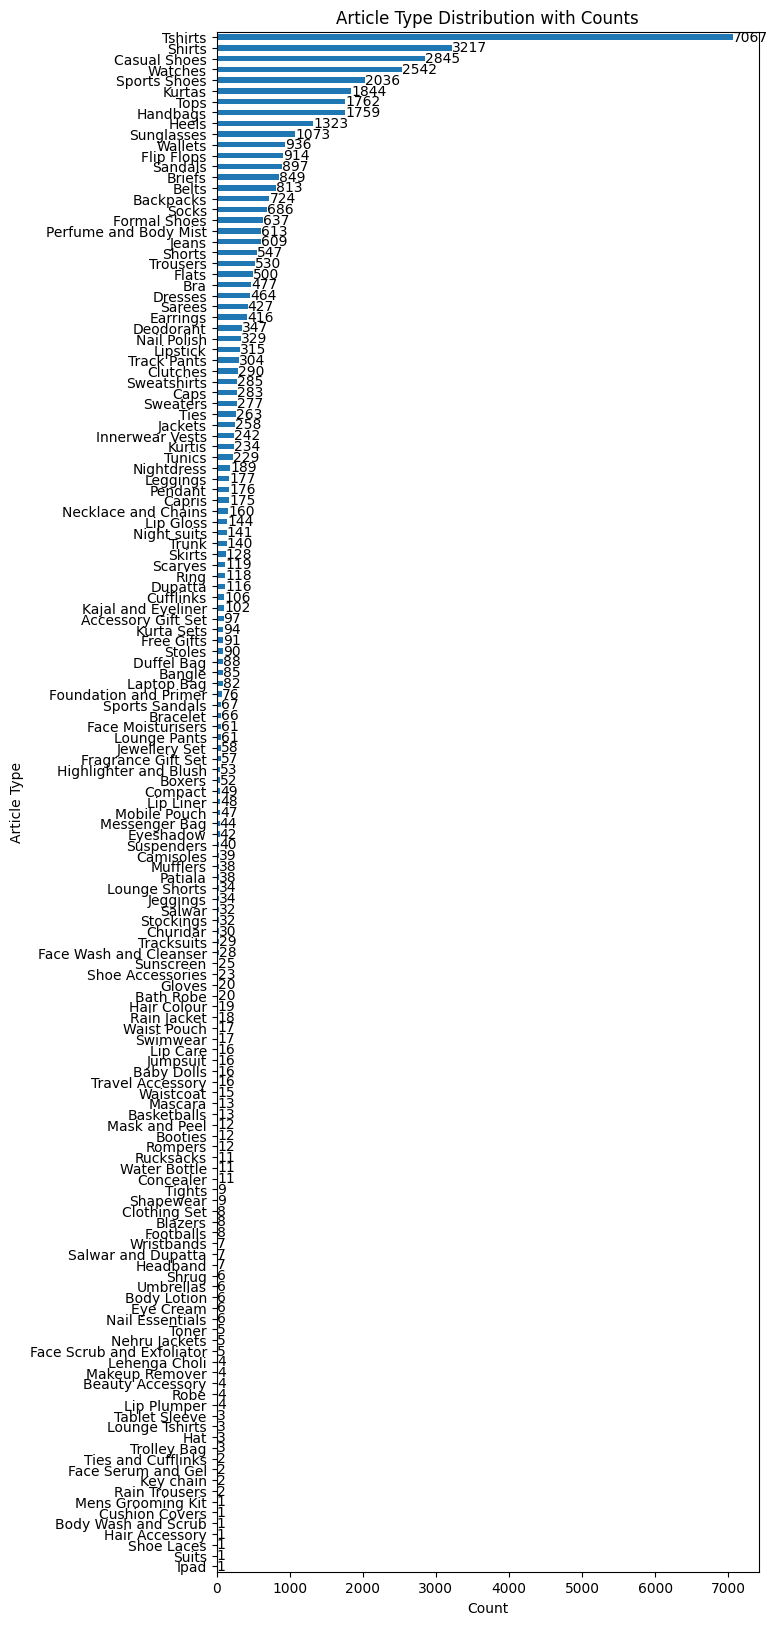

In [ ]:
# Bar plot for article type distribution with counts
plt.figure(figsize=(7, 20))
ax = data['articleType'].value_counts().sort_values().plot(kind='barh')

for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.xlabel("Count")
plt.ylabel("Article Type")
plt.title("Article Type Distribution with Counts")
plt.show()

As you could see above there is a clear imbalance in the dataset, with Tshirts and Shirts having the highest frequency. One possible solution was to remove all article types that have a count of 1000 or less to reduce the noise in the dataset, making it perform better on the article types with many instances. However, I decided to use all the article types to test if the model can still make accurate predictions and visually similar recommendations with the extra noise.


Now let's view the data to see what we're working with.

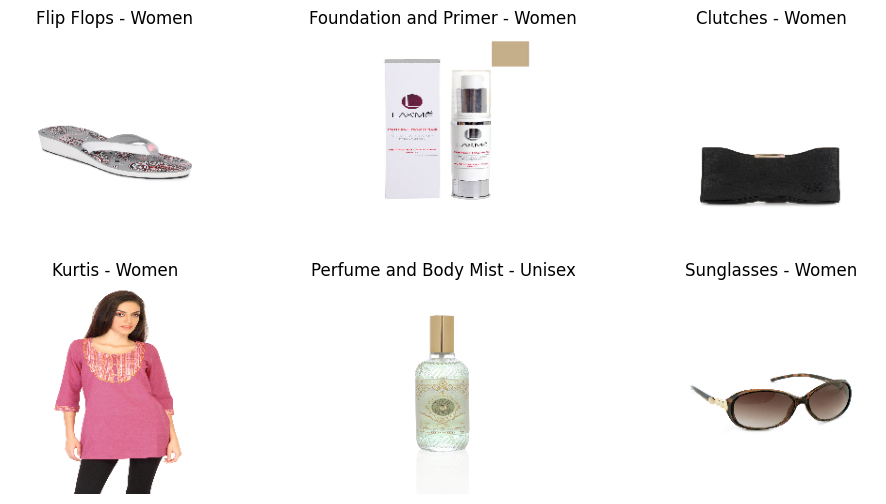

In [ ]:
# Sample a few images with article types for visualisation
sample_data = data.sample(6)

plt.figure(figsize=(12, 6))
for i, row in enumerate(sample_data.itertuples()):
    img_path = row.filename
    img = load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"{row.articleType} - {row.gender}")
    plt.axis('off')
plt.show()

With this small sample of data, the images appear to be clear and is suitable for training a model with, avoiding the 'Garbage In, Garbage Out' problem.

In [ ]:
# See any missing values
data.isnull().sum()

,0
id,0
gender,0
masterCategory,0
subCategory,0
articleType,0
baseColour,15
season,21
year,1
usage,317
filename,0


In [ ]:
# Drop rows with missing values
print("Before dropping rows:", len(data)) # Number of data points before dropping data points with null or missing values
data = data.dropna()
print("After dropping rows:", len(data)) # Number of data points after dropping data points with null or missing values

Before dropping rows: 44424
After dropping rows: 44079


# Train-Test Split, Data Augmentation and Data Generators

Test-train split allows the model to be trained on the majority of the data (80% in this case) while the rest is set aside as unseen data to be used to evaluate the model's performance. An 80-20 split was chosen due to the large size of the dataset. A random state of 42 was included for producability and stratifying was dataset on the target variable was tested, however it yielded in a decrease in model performance.





In [ ]:
# Train-Test Split
train, val = train_test_split(data, test_size=0.2, random_state=42)

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

ImageDataGenerators are set up to preprocess the data before it is fed into the model. By scaling the pixel values in the data from [0, 255] to [0, 1], it helps in stabilising and speeding up the model. Additionally, neural networks perform better when the data has been normalised.

Additionally, data augmentations were applied to the training dataset to improve generalisation of the model. Data augmentation artificially increases the diversity of the dataset by applying random transformations. This helps reduce the risk of overfitting in the model.

The below data augmentations were chosen as fashion images tend to vary in the real world, making the dataset reflective of other fashion images you may find online. The selected data augmentations were tested and found to yield the best results - the augmentations are minimal to reduce extra noise which may affect the model's performance and convergence.

In [ ]:
# Set up ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    horizontal_flip=True,  # Randomly flip images horizontally
    rotation_range=10,  # Small rotations
    width_shift_range=0.1,  # Small horizontal shifts
    height_shift_range=0.1,  # Small vertical shifts
    zoom_range=0.1,  # Small zoom in/out
    fill_mode="nearest" # Use nearest fill to handle empty areas in images after transformation (due to rotation, shifts and zooms)
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255) # Normalize pixel values to [0, 1]

The generators are set up to allow the model to continuously load and process images in memory without requiring the entire dataset to be loaded at once. This is particularly useful as we are dealing with a large image dataset.

Additionally, the class_mode is set to 'sparse' so integer labels are provided for each class, rather than one-hot encoded vectors. This is necessary for triplet loss in embedding models to correctly identify positive and negative samples based on similarity, more on this later.

In [ ]:
# Create train generator
train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='filename',  # Column containing image file paths
    y_col='articleType',  # Column containing labels (article types)
    target_size=(224, 224),  # Resize images to 224x224 pixels (necessary for ResNet50V2 model) - the images in the dataset vary, but most are above greater than 224x224 pixels
    batch_size=32,  # Number of samples per batch
    class_mode='sparse'  # Required for triplet loss; provides integer labels
)

# Create validation generator
val_generator = val_datagen.flow_from_dataframe(
    val,
    x_col='filename',
    y_col='articleType',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',  # Also provides integer labels for evaluation
    shuffle=False  # No need to shuffle validation data, the default of this parameter is True
)

Found 35258 validated image filenames belonging to 141 classes.
Found 8816 validated image filenames belonging to 121 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 5 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


# Initialise and train the Model

**ResNet50V2** is an optimised pre-trained model that was trained on the ImageNet dataset (a very large dataset - 1 million images with 1000 different classes), making it ideal to leverage for feature extraction and transfer learning rather than training a custom CNN from scratch. Additionally, we remove the top layers of the ResNet50V2 model via 'include_top=False', keeping only the convolutional layers for extracting features. The top layers are not relevant to our dataset.

Due to fashion items being visually distinct and their appeal often depending on features like texture, shapes, and patterns, ResNet50V2's deep architecture with 50 convolutional layers is well suited to this task. It can capture low-level features like colours and edges, as well as high-level patterns like shapes and textures. For example, the model may differentiate the fabric of shirts and the leather of wallets, as well as floral designs and polka designs, and the shape differences between backpacks and handbags.

Due to the imbalanced nature of the dataset, the residual connections and pre-activation layers ensure efficient gradient flow, allowing the model to generalise well across frequent and infrequent classes.

ResNet50v2 Architecture:

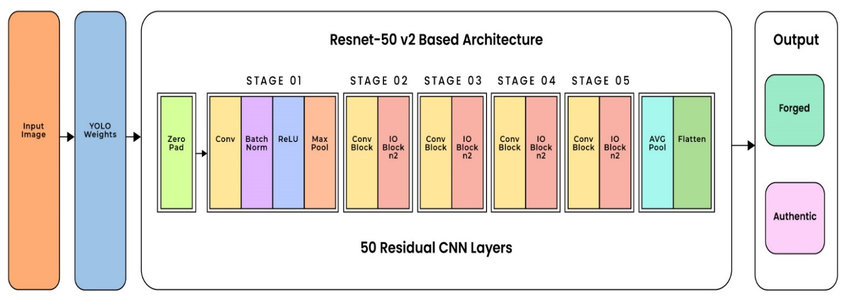

*Sourced from: https://www.researchgate.net/figure/ResNet50v2-architecture_fig1_359153551*

The ResNet50V2 is a deep CNN model, but is a 50-layer variant of the original ResNet model. It was developed to address the vanishing gradient problem in deep networks. Due to deep neural networks suffering from degradation problems, the ResNet introduces residual learning, which adds shortcut connections that may skip a singular or multiple layers, which improves the gradients flow through the network during backpropagation. Additionally, this model uses many Batch Normalisation layers, which normalise inputs before every weight layer. This stabilises learning and accelerates convergence. This variant model addresses some of the limitations of the original ResNet model.

Here's a great website that visualises how neural networks work:
https://adamharley.com/nn_vis/cnn/2d.html



---

  



A **GlobalAveragePooling2D** was added to reduce the spatial dimensions of the feature maps generated by the ResNet model, summarising them into a single vector of 2048 values. This is ideal for similarity learning and helps prevent overfitting.

We freeze all layers except the last 5 layers of the ResNet model. Freezing the layers allows the weights to be kept constant during training as the model has previously been trained and optimised on the ImageNet dataset. We fine-tuned the model by unfreezing the last 5 layers, allowing it to adapt to our dataset, as it was observed to yield the best results via testing.


**Adam (Adaptive Moment Estimation)** was chosen as the optimiser as it's a classic optimiser that works well for similarity search tasks. It's most known for adapting the learning rate of each parameter, allowing for faster convergence and better performance.

A **Triplet Loss** function is used for this model as it needs to learn a similarity between images. It works by comparing distances between an anchor image, a positive image (an image similar to the anchor image), and a negative image (an image dissimilar to the anchor image). The goal is to ensure that the embeddings for similar images are close together in the embedding space and vice versa for the dissimilar images. In this implementation, we use a variation of the Triplet Loss that focuses on semi-hard negatives, which allows the model to focus on challenging cases (semi-hard negatives) that still contribute to the learning, avoiding easy negatives. This approach is better than the standard Triplet Loss approach as hard negatives can cause the model to oscillate, which can destabilise the model during training. This results in better learning on difficult images.

An **embedding model** was used because it transforms images into low-dimensional dense vector representations (embeddings), which capture the features of each image. This is ideal for similarity image searches like image recommendation and clustering.

Here are some other reasons why an embedding model is suitable for this task if you remain unconvinced:



1.   Embedding models can learn and capture high-level patterns in images.
2.   Embedding models map each image to a fixed-length vector. This allows images to be directly compared in a vector space, making it ideal for similarity searches.

3.   It is computationally efficient to use images represented as embeddings for metrics like Euclidean distance. You'll see why this is ideal when Euclidean distance is explained later on.
4.   Since we're using a variation of Triplet Loss (which is very ideal for similarity searches), embeddings are necessary to enable this loss function to work effectively.





In [ ]:
# Defines input layer with the shape of images (224x224 RGB)
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)

# Load ResNet50V2 base model for transfer learning
# Exclude the top layers with 'include_top=False' so only the convolutional layers are loaded for feature extraction.
base_model = ResNet50V2(weights='imagenet', include_top=False, input_tensor=inputs)
x = GlobalAveragePooling2D()(base_model.output)   # Reduces dimensionality of the feature maps to 2048, summarizing them into a single vector per feature
embedding_model = Model(inputs=base_model.input, outputs=x) # Create the full model with the custom input and output

# Unfreeze the last 5 layers
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Compile embedding model with a low learning rate (0.00001) for fine-tuning with TripletSemiHardLoss as the loss function.
embedding_model.compile(optimizer=Adam(learning_rate=1e-5),
                        loss=tfa.losses.TripletSemiHardLoss())

embedding_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

Other additional layers, such as dropout and extra batch normalisation layers were tested, however the current model setup yielded the best results thus far.

In [ ]:
# Train the model, using the validation data for evaluation
embedding_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

Epoch 1/10
1102/1102 [==============================] - 1102s 978ms/step - loss: 0.1811 - val_loss: 0.0857
Epoch 2/10
1102/1102 [==============================] - 1070s 971ms/step - loss: 0.0772 - val_loss: 0.0585
Epoch 3/10
1102/1102 [==============================] - 1084s 984ms/step - loss: 0.0553 - val_loss: 0.0467
Epoch 4/10
1102/1102 [==============================] - 1079s 979ms/step - loss: 0.0475 - val_loss: 0.0405
Epoch 5/10
1102/1102 [==============================] - 1079s 979ms/step - loss: 0.0406 - val_loss: 0.0337
Epoch 6/10
1102/1102 [==============================] - 1084s 983ms/step - loss: 0.0355 - val_loss: 0.0323
Epoch 7/10
1102/1102 [==============================] - 1076s 976ms/step - loss: 0.0329 - val_loss: 0.0304
Epoch 8/10
1102/1102 [==============================] - 1083s 983ms/step - loss: 0.0291 - val_loss: 0.0296
Epoch 9/10
1102/1102 [==============================] - 1089s 988ms/step - loss: 0.0282 - val_loss: 0.0267
Epoch 10/10
1102/1102 [==============

The above results are very promising, with a training loss of 2.56% and a validation loss of 2.70%. However, the validation loss begins to increase after 9 epochs, meaning the model may have begun to overfit the data. Early stopping at 9 epochs or a reduced learning rate may improve the model's performance. However, due to the computational intensity of this task, we will use this model as it is without the extra fine-tuning, to save time and resources.

We will now save the model so it can be used again without having to re-train the model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Saving the model to Google Drive (only saves if it doesn't exist)

# Save path
save_path = '/content/drive/MyDrive/embedding_model.keras'

# Check if the file already exists
if not os.path.exists(save_path):
    # Save the model if it doesn't exist
    embedding_model.save(save_path)
    print("Model saved successfully.")
else:
    print("Model already exists, skipping save.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model already exists, skipping save.


In [ ]:
# Load the saved model
embedding_model = load_model('/content/drive/MyDrive/embedding_model.keras', custom_objects={'TripletSemiHardLoss': tfa.losses.TripletSemiHardLoss()})

In [ ]:
# Extract embeddings from the train and validation sets
train_embeddings = embedding_model.predict(train_generator, verbose=1)
val_embeddings = embedding_model.predict(val_generator, verbose=1)

276/276 [==============================] - 148s 535ms/step


We will now save the embeddings so it can be used again without having to extract the embeddings again.

In [ ]:
# Save train and validation embeddings to Google Drive (only saves if it doesn't exist)

# Save train embeddings to Google Drive
train_save_path = '/content/drive/MyDrive/train_embeddings.npy'
if not os.path.exists(train_save_path):
    np.save(train_save_path, train_embeddings)
    print("Train embeddings saved successfully.")
else:
    print("Train embeddings already exist, skipping save.")

# Save validation embeddings to Google Drive
val_save_path = '/content/drive/MyDrive/val_embeddings.npy'
if not os.path.exists(val_save_path):
    np.save(val_save_path, val_embeddings)
    print("Validation embeddings saved successfully.")
else:
    print("Validation embeddings already exist, skipping save.")

In [ ]:
# Load embeddings from saved files in Google Drive
train_embeddings = np.load('/content/drive/MyDrive/train_embeddings.npy')
val_embeddings = np.load('/content/drive/MyDrive/val_embeddings.npy')

# Dimensionality Reduction

In the **embedding_model.summary()** we see the output dimensionality of the data is 2048, this can lead to several issues, such as:



*   **Computational efficiency**: High-dimensional data is computationally expensive, making Nearest Neighbour searches for visually similar images difficult.
*   **High dimensionality**: This makes the data more sparse, and distance metric systems become less meaningful.

PCA (Principal Component Analysis) is a dimensionality reduction technique that is ideal for high-dimensional data while preserving as much information from the data as possible. PCA transforms the data into principal components, which is ideal for Nearest Neighbour searches.

In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA()
train_embeddings_pca = pca.fit_transform(train_embeddings)
variance_explained = np.cumsum(pca.explained_variance_ratio_)

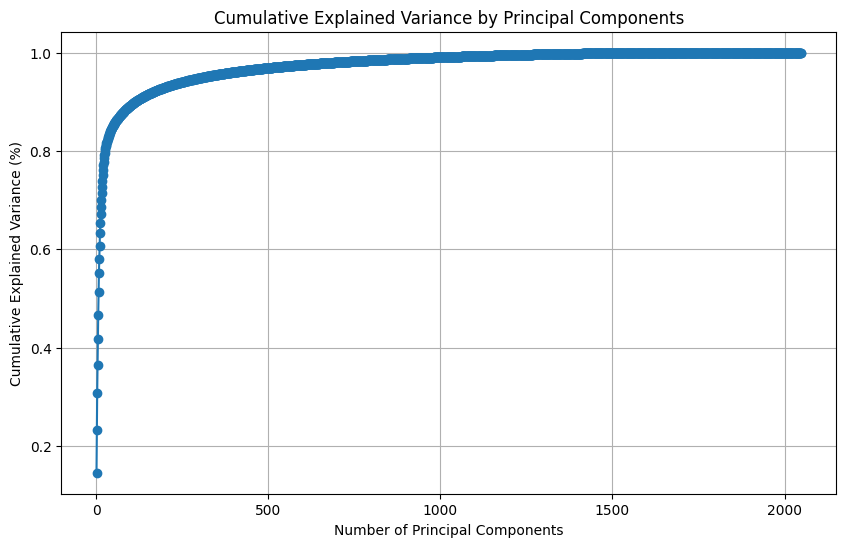

In [ ]:
# Plot cumulative explained variance by principal components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(variance_explained) + 1), variance_explained, marker='o')
plt.title("Cumulative Explained Variance by Principal Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.grid(True)
plt.show()

In the graph above, the explained variance plateaus at around 1000 principal components (which is likely 99% of the explained variance).

We decide to select the principal components covering 99% of the variance to reduce the dimensionality while preserving the majority of the information, striking an ideal balance.

In [ ]:
# Select components covering 99% variance
n_components = np.argmax(variance_explained >= 0.99) + 1
pca = PCA(n_components=n_components)
train_embeddings_pca = pca.fit_transform(train_embeddings)
val_embeddings_pca = pca.transform(val_embeddings)

In [ ]:
train_pca_df = pd.DataFrame(train_embeddings_pca)
val_pca_df = pd.DataFrame(val_embeddings_pca)
val = val.reset_index(drop=True)
val = pd.concat([val.iloc[:, :10], val_pca_df], axis=1)

In [ ]:
print("Reduced dimensionality after PCA:", train_embeddings_pca.shape)

Reduced dimensionality after PCA: (35258, 970)


We see 970 components contributes to 99% of the variance

In [ ]:
# Prepare data for similarity search
X = val.iloc[:, -n_components:]
y = val['articleType']

# Visually similar product recommendation system using NearestNeighbors

Nearest Neighbours is implemented to make predictions based on the similarity between the stored data and the input data. It is useful for finding images that are most similar to an input image based on their feature representations. This similarity search is ideal for recommendation systems. Since we have already reduced the dimensionality of the data, Nearest Neighbours is effective.

Euclidean distance is the chosen metric for the Nearest Neighbours model. It is used to measure the straight-line distance between two points in Euclidean space. Since the data points are continuous vectors, Euclidean distance is effective in measuring similarity. Manhattan and Cosine were tested, and Euclidean was found to yield the best results.

Precision@K is an evaluation metric used to measure the relevance of the top-K recommendations provided by the model. This metric is used to express the quality of the recommendations from a user's perspective.

Recall@K is also an evaluation metric, but instead of measuring relevance, it measures the proportion of the relevant items that are successfully retrieved among the top-K recommendations. However, since we are only recommending a low-K of products, Recall will be very low, making this metric less meaningful as it will always be very low at low-K.

Typically, incorporating Recall@K and F1@K (or weighted F1 due to using an imbalanced dataset) would be ideal for showing the model's overall performance.

In [ ]:
# Fit Nearest Neighbors model on PCA-reduced train embeddings for similarity search
neighbor_model = NearestNeighbors(n_neighbors=10, metric='euclidean')
neighbor_model.fit(X)

# Function to calculate Average Precision@K
def avg_k_prec(sample_size=200, k=5, model=neighbor_model):
    precisions = []
    for _ in range(sample_size):
        query_index = random.randint(0, len(X) - 1)  # Randomly select a query index from the data
        true_label = y.iloc[query_index]

        # Nearest neighbor search using the model
        distances, indices = model.kneighbors([X.iloc[query_index]], n_neighbors=k)
        recommended_labels = y.iloc[indices[0]]

        # Calculate Precision@K
        correct_recommendations = sum(recommended_labels == true_label)
        precision = correct_recommendations / k
        precisions.append(precision)

    # Calculate and print the average precision over the sample size
    avg_precision = np.mean(precisions)
    print(f"Average Precision@{k} (over {sample_size} samples): {avg_precision}")
    return avg_precision

# Calculate Average Precision@K for multiple values of K
avg_k_prec(sample_size=1000, k=3, model=neighbor_model)
avg_k_prec(sample_size=1000, k=5, model=neighbor_model)
avg_k_prec(sample_size=1000, k=10, model=neighbor_model)

Average Precision@3 (over 1000 samples): 0.8993333333333332
Average Precision@5 (over 1000 samples): 0.848
Average Precision@10 (over 1000 samples): 0.8168


0.8168

We see a very high Precision@3/5 but begins to decrease with higher K's. This is ideal for the purpose of this task.

In [ ]:
# Function to read and preprocess images
def read_img(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    return image

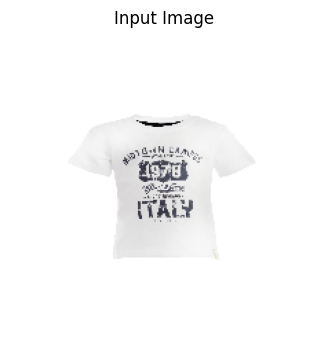

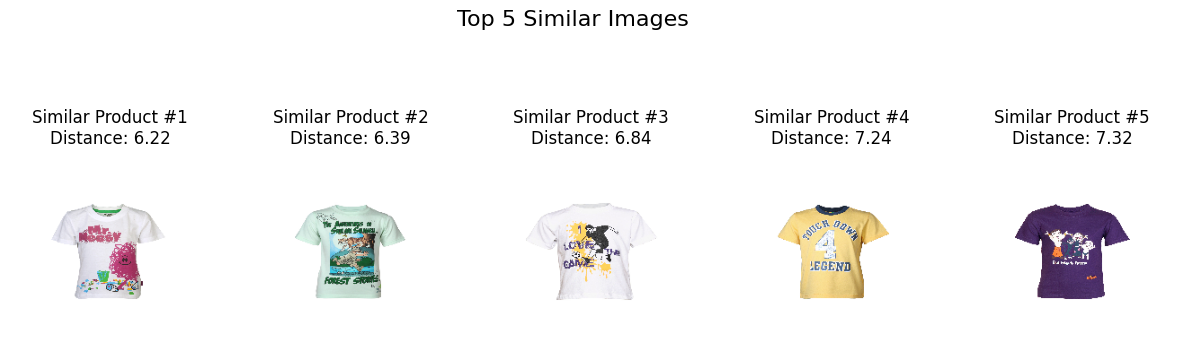

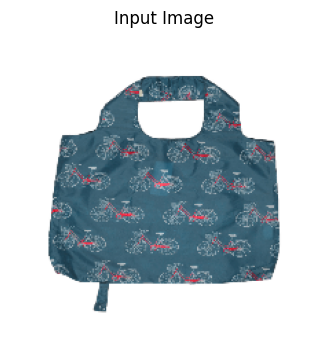

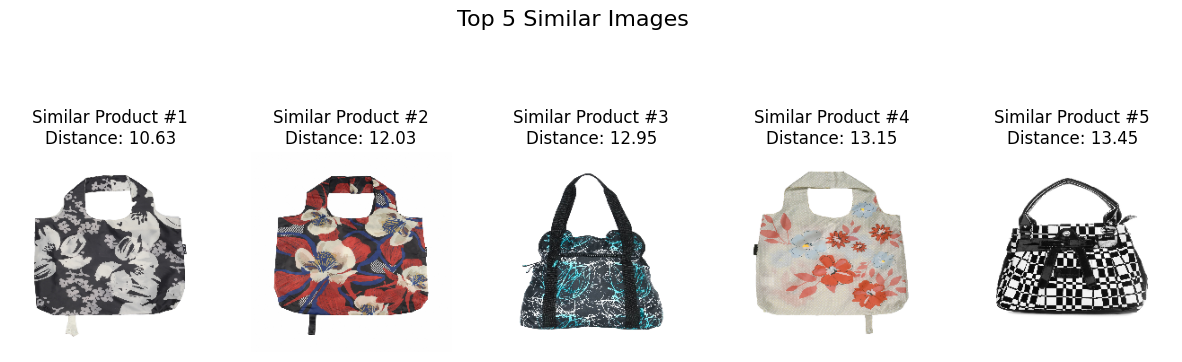

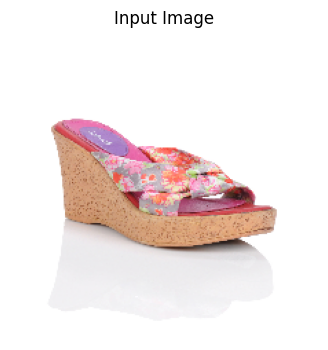

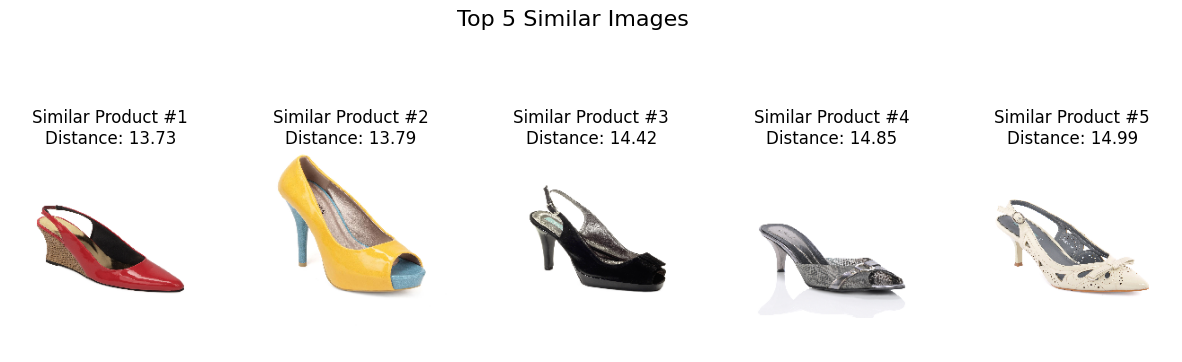

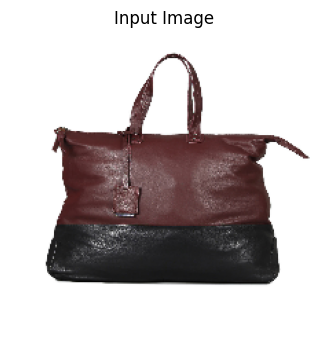

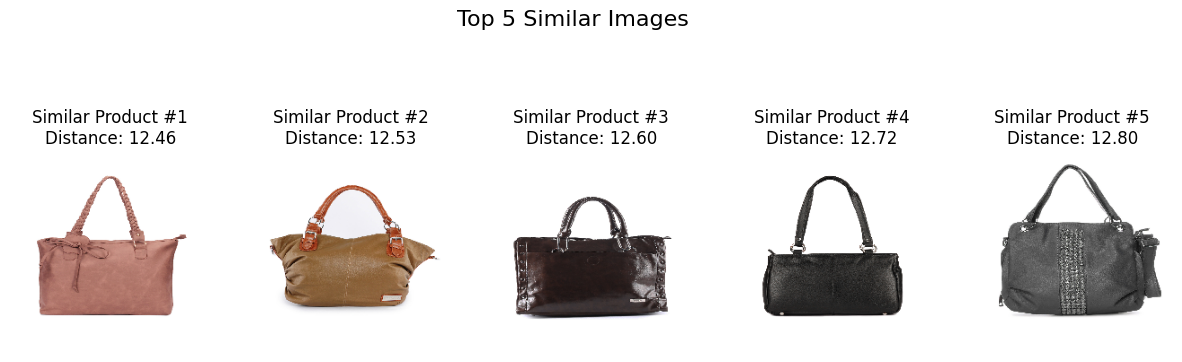

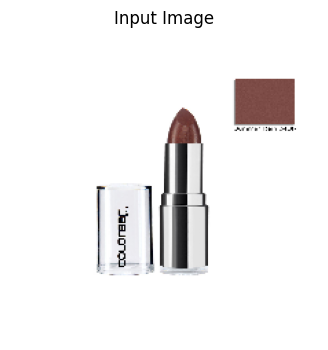

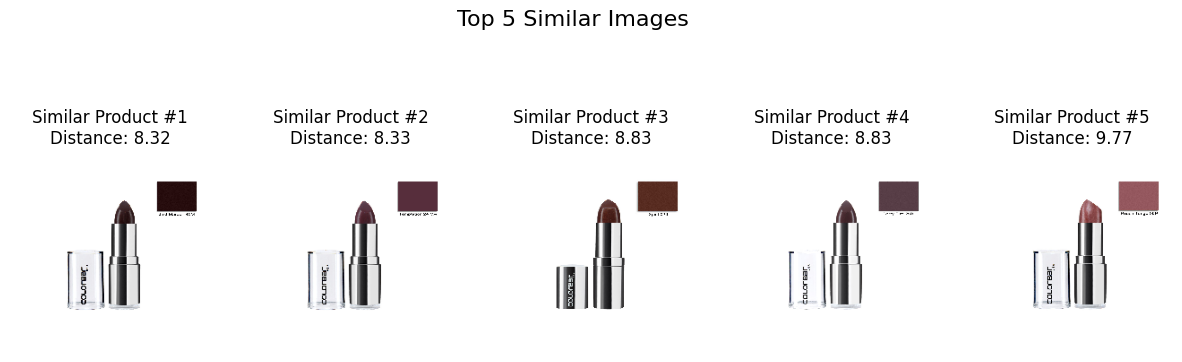

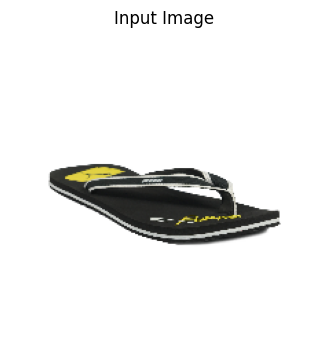

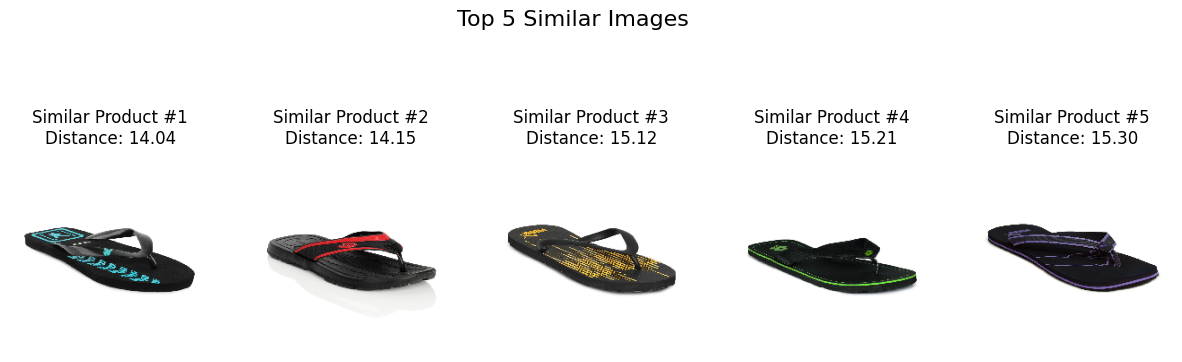

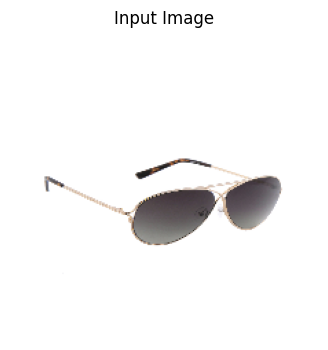

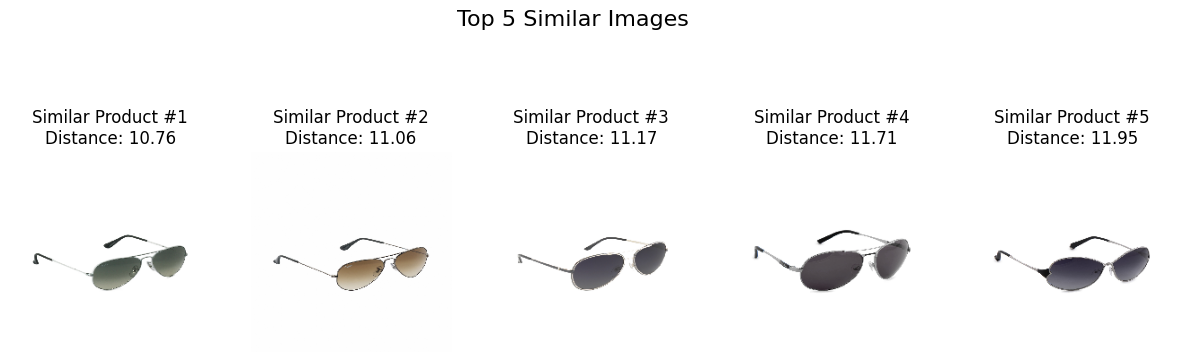

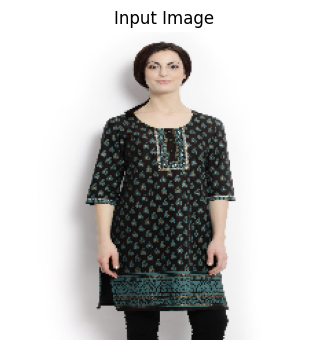

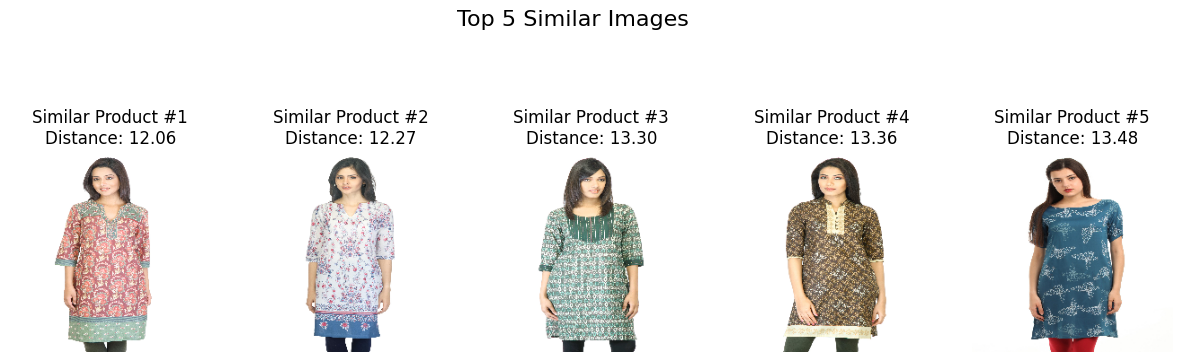

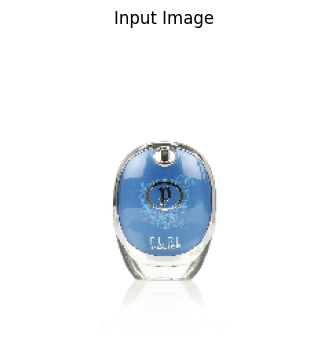

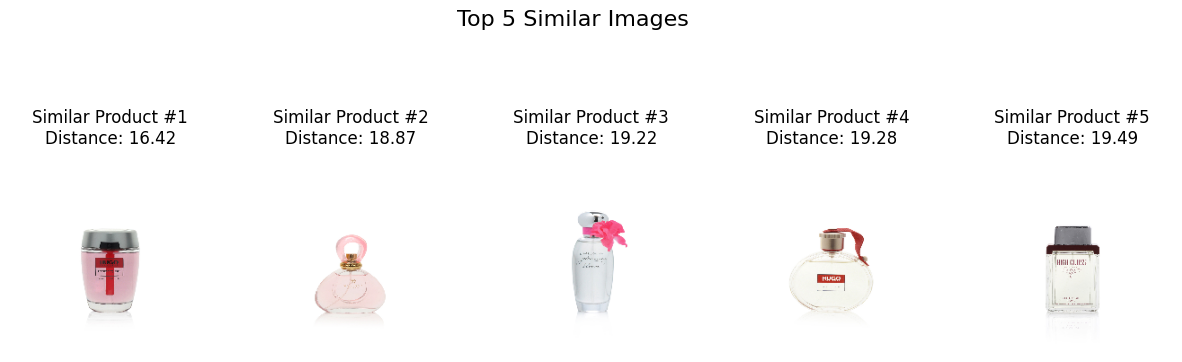

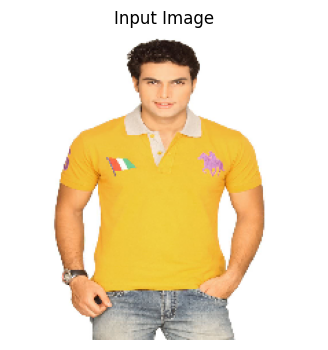

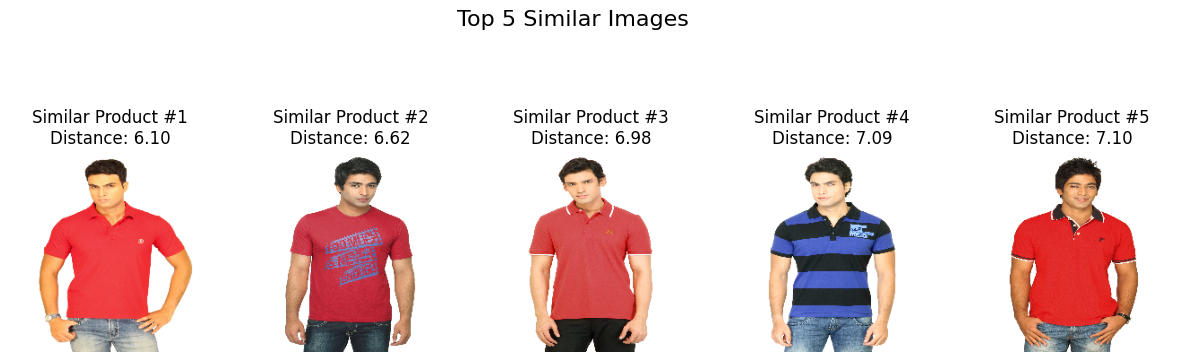

In [ ]:
# Display query and similar images for randomly chosen validation samples
for _ in range(10):
    i = random.randint(0, len(val) - 1)
    img1 = read_img(val.loc[i, 'filename'])

    dist, indices = neighbor_model.kneighbors([X.iloc[i]], n_neighbors=6)

    plt.figure(figsize=(4, 4))
    plt.imshow(img1)
    plt.title("Input Image")
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(15, 5))
    similar_count = 0
    for j in range(1, len(indices[0])):
        if similar_count < 5:
            similar_img = read_img(val.loc[indices[0][j], 'filename'])
            plt.subplot(1, 5, similar_count + 1)
            plt.imshow(similar_img)
            plt.title(f'Similar Product #{similar_count + 1}\nDistance: {dist[0][j]:.2f}')
            plt.axis('off')
            similar_count += 1
    plt.suptitle("Top 5 Similar Images", fontsize=16)
    plt.show()

The above results is very promising, for every random image that was selected the model recommended visually similar images.

Here you can upload any image too test the model!

**Please be aware you will be prompted with an upload dialog and a text dialog after every set of recommendations (loop is infinite until manually broken)**

Saving 76c32d_7dbb7a7ef8e94adf98bf209ef1f266b4~mv2.jpg to 76c32d_7dbb7a7ef8e94adf98bf209ef1f266b4~mv2 (1).jpg
1/1 [==============================] - 1s 1s/step


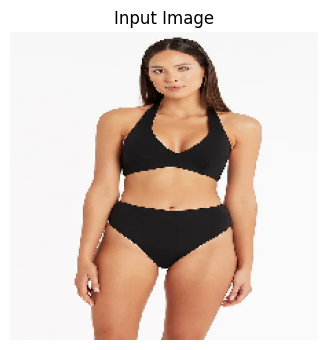

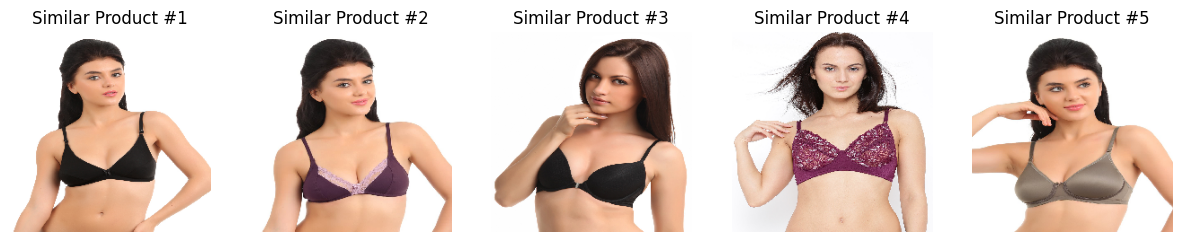

Do you want to select another image? (y/n): y


Saving 30465374781470.jpg to 30465374781470.jpg
1/1 [==============================] - 0s 25ms/step


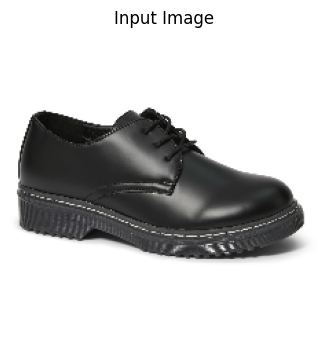

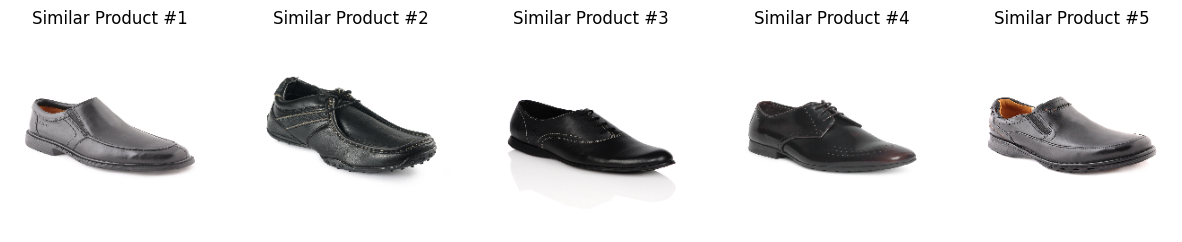

Do you want to select another image? (y/n): n


In [ ]:
# Upload custom images and get recommendations
while True:
    uploaded = files.upload()

    image_path = list(uploaded.keys())[0]

    img1 = read_img(image_path)

    input_image_features = embedding_model.predict(img1.reshape(1, 224, 224, 3))
    input_image_features_pca = pca.transform(input_image_features)

    dist, index = neighbor_model.kneighbors(X=input_image_features_pca)

    plt.figure(figsize=(4, 4))
    plt.imshow(img1)
    plt.title("Input Image")
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(15, 5))
    for j in range(5):
        similar_img = read_img(val.loc[index[0][j], 'filename'])
        plt.subplot(1, 5, j + 1)
        plt.imshow(similar_img)
        plt.title(f'Similar Product #{j+1}')
        plt.axis('off')
    plt.show()

    cont = input("Do you want to select another image? (y/n): ")
    if cont.lower() != 'y':
        break


## Recommendations for possible improvements

1.   Due to the imbalanced nature of the dataset, removing article types with a limited number of instances may increase the performance of the model.
2.   For the rows with missing data points, instead of removing rows with missing data points, we could test removing whole columns instead. When I searched for missing data, there were 317 instances of missing data in the 'usage' column, which indicates whether the article type is intended for casual or formal attire. This would have saved many images for training, which may have led to a slightly increased performance.

3.   Instead of training one model with the whole dataset or removing article types with fewer than desired instances, implementing a solution that includes segmented training, bagging, and ensemble aggregation into a unified framework may be beneficial. For example, three models can be trained using a segmented version of the dataset, with the segments containing high, medium, and low article type frequencies, for example:
- The first model will train on article types with counts of 1000+.
- The second model will train on items with 1000-500 counts.
- And the third model trains on 500-100 counts.

  After making predictions, you could then aggregate the predictions from the models using weighted voting or stacking. This approach addresses the imbalance problem, simplifies learning, and would increase the robustness of the model via ensemble aggregation, rather than using a vanilla CNN.

4.   Instead of only retrieving the most visually similar products, also displaying the most dissimilar products with the furthest euclidean distance.
